In [1]:
import warnings;
warnings.simplefilter('ignore')

# Install and Import Dependencies

In [2]:
# !pip install pystan prophet  ## If you don't have pystand and prophet installed run this cell.

In [3]:
import pandas as pd
from prophet import Prophet

# Data Preprocessing

In [4]:
# Read the data into a Pandas DataFrame
ecommerce_df = pd.read_csv('../Resources/Ecommerce_Data_Updated.csv')
print(f"{ecommerce_df.shape} is the number of the rows and columns in the dataset.")
ecommerce_df.head()

(9994, 18) is the number of the rows and columns in the dataset.


,Order Date,Ship Date,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit,Sales Per Unit,Original Unit Price,Lead Time
0,2022-11-07,2022-11-10,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,261.9600,2,0.00,41.9136,130.9800,130.98,3 days
1,2022-11-07,2022-11-10,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Chairs,731.9400,3,0.00,219.5820,243.9800,243.98,3 days
2,2022-06-11,2022-06-15,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,14.6200,2,0.00,6.8714,7.3100,7.31,4 days
3,2021-10-09,2021-10-16,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Furniture,Tables,957.5775,5,0.45,-383.0310,191.5155,348.21,7 days
4,2021-10-09,2021-10-16,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Office Supplies,Storage,22.3680,2,0.20,2.5164,11.1840,13.98,7 days


In [5]:
# Check the columns
print(f"{len(ecommerce_df.columns)} --> is the number of columns in our DataFrame.")
ecommerce_df.columns

18 --> is the number of columns in our DataFrame.


Index(['Order Date', 'Ship Date', 'Ship Mode', 'Segment', 'Country', 'City',
       'State', 'Postal Code', 'Region', 'Category', 'Sub-Category', 'Sales',
       'Quantity', 'Discount', 'Profit', 'Sales Per Unit',
       'Original Unit Price', 'Lead Time'],
      dtype='object')

In [6]:
# Drop unwanted columns    
## Keeping only numerical columns so we can get the average of each column per "Order Date"
### NOTE: "fbprophet" takes only two columns & one of the columns has to be a date.
ecommerce_df = ecommerce_df.drop(columns = ["Ship Date", "Ship Mode", "Segment",
                                            "Country", "City", "State", "Postal Code", 
                                            "Sales Per Unit", "Lead Time",
                                            "Category", "Sub-Category",
                                            "Quantity", "Discount", "Original Unit Price",
                                            "Region"])  


# printing the number of rows and columns
print(ecommerce_df.shape) 
# print the DataFrame in descending order - starting from the most recent date.
ecommerce_df.sort_values(by = "Order Date", ascending = False).head() 

(9994, 3)


,Order Date,Sales,Profit
906,2023-12-29,323.136,12.1176
907,2023-12-29,90.930,2.7279
1296,2023-12-29,13.904,4.5188
1297,2023-12-29,20.720,6.4750
645,2023-12-29,209.300,56.5110


In [7]:
## Group by the "Order Date". Then take the average of each column
ecommerce_df = ecommerce_df.groupby("Order Date")
ecommerce_df_mean = ecommerce_df.mean().reset_index() 

print(ecommerce_df_mean.shape)
ecommerce_df_mean.sort_values(by = "Order Date", ascending = False).head() 

(1237, 3)


,Order Date,Sales,Profit
1236,2023-12-29,101.970000,14.505214
1235,2023-12-28,242.961167,53.702817
1234,2023-12-27,87.228989,13.322042
1233,2023-12-26,88.818000,-15.987100
1232,2023-12-25,203.648500,15.280050


## Predicting the `Profit` 

In [8]:
# Keep only the "Order Date" and the "Profit" columns 
ecommerce_df_mean.drop(['Sales'], axis=1, inplace=True)

# Rename "Order Date" to "ds" 
# and the "Profit" column to "y" 
ecommerce_df_mean.columns = ['ds', 'y']  

print(f"{ecommerce_df_mean.shape} is the number of rows and columns that will be used in our forecast.")
# print the DataFrame in ascending order - starting from the oldest date.
ecommerce_df_mean.sort_values(by = "ds", ascending = True).head()                    

(1237, 2) is the number of rows and columns that will be used in our forecast.


,ds,y
0,2020-01-02,5.551200
1,2020-01-03,-21.996700
2,2020-01-04,4.884000
3,2020-01-05,150.894711
4,2020-01-06,-35.981050


In [9]:
## Just for curiosity! The first and last dates in our dataset
print(ecommerce_df_mean["ds"].min())
print(ecommerce_df_mean["ds"].max())

2020-01-02
2023-12-29


# Train The Model

In [10]:
# NOTE: interval_width is the width of the uncertainty intervals provided for the forecast.
m = Prophet(interval_width=0.95, daily_seasonality=True)
model = m.fit(ecommerce_df_mean)

15:46:11 - cmdstanpy - INFO - Chain [1] start processing
15:46:12 - cmdstanpy - INFO - Chain [1] done processing


# `Profit` Forecasting

In [11]:
# Forecasting the "Profit" for the coming 365 days from the last recorded data that we have.
future = m.make_future_dataframe(periods=365, freq='D', include_history = False)  
forecast = m.predict(future)

## Just for curiosity
print(forecast["ds"].min())
print(f'{forecast["ds"].max()} \n')
print(forecast.shape)

forecast.head()  

2023-12-30 00:00:00
2024-12-28 00:00:00 

(365, 22)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-12-30,18.169704,-173.503787,214.436086,18.169704,18.169704,8.005942,8.005942,8.005942,8.969865,...,0.782357,0.782357,0.782357,-1.746280,-1.746280,-1.746280,0.0,0.0,0.0,26.175646
1,2023-12-31,18.154035,-180.461615,235.701878,18.154035,18.154035,8.820003,8.820003,8.820003,8.969865,...,3.434023,3.434023,3.434023,-3.583886,-3.583886,-3.583886,0.0,0.0,0.0,26.974037
2,2024-01-01,18.138365,-166.889746,225.287962,18.138365,18.138365,5.052294,5.052294,5.052294,8.969865,...,1.562853,1.562853,1.562853,-5.480424,-5.480424,-5.480424,0.0,0.0,0.0,23.190659
3,2024-01-02,18.122696,-178.730416,217.426742,18.122368,18.123272,-1.561677,-1.561677,-1.561677,8.969865,...,-3.123724,-3.123724,-3.123724,-7.407818,-7.407818,-7.407818,0.0,0.0,0.0,16.561019
4,2024-01-03,18.107027,-179.812468,205.352042,18.106038,18.108569,-2.749261,-2.749261,-2.749261,8.969865,...,-2.380665,-2.380665,-2.380665,-9.338461,-9.338461,-9.338461,0.0,0.0,0.0,15.357766


Text(62.597222222222214, 0.5, 'Profit')

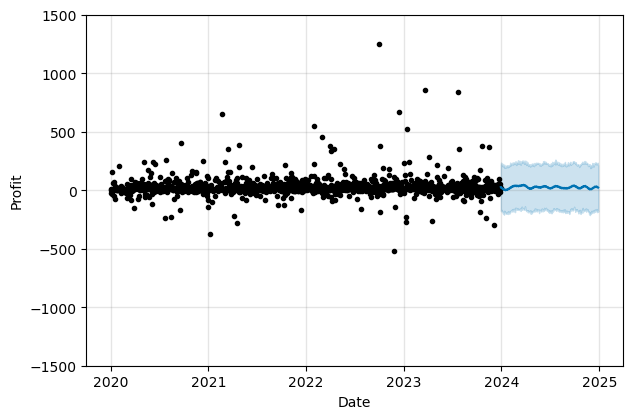

In [12]:
plot1 = m.plot(forecast)  

# Set the limit of the y-axis
plot1.gca().set_ylim(-1500, 1500)

# Resize the plot
plot1.set_size_inches(6,4)

# gca --> "get the current axis" and set it to the desired name.
plot1.gca().set_xlabel("Date")
plot1.gca().set_ylabel("Profit")

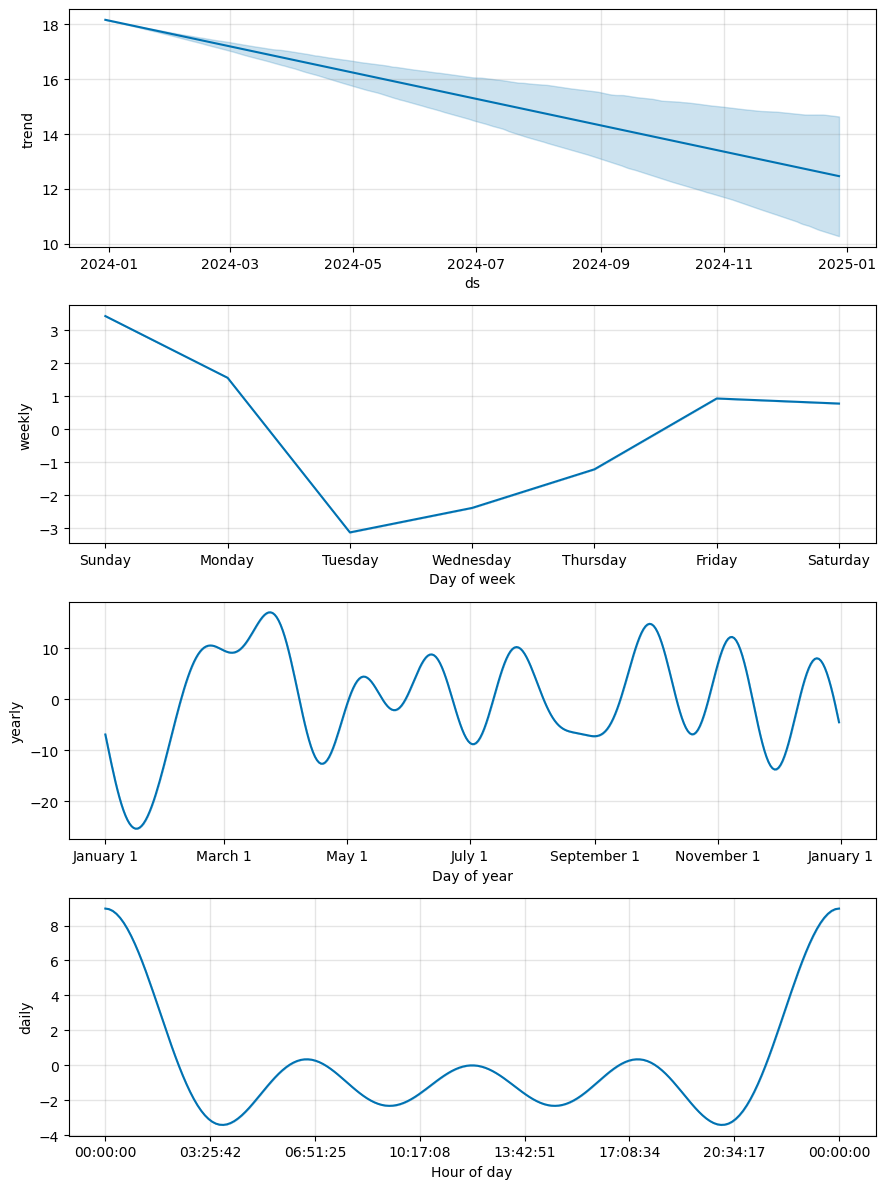

In [13]:
plt2 = m.plot_components(forecast)  ## high level of certainty --> Then the margins are getting wider 